# SSA Data Pipeline
This notebook contains an orchestrated end-to-end pipeline for ingesting, cleaning, and analyzing Social Security Administration (SSA) disability benefits data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime
import logging
from typing import Dict, List, Tuple, Optional
import json

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [15]:
# Orchestrated pipeline for SSA data processing and analysis
class SSADataPipeline:
    def __init__(self, data_path: str = "SSA-SA-FYWL.csv"):
        self.data_path = data_path
        self.raw_data = None
        self.cleaned_data = None
        self.data_quality_report = {}
        self.analysis_results = {}
        
        # Column mapping for better readability
        self.column_mapping = {
            'Region Code': 'Region',
            'State Code': 'State',
            'Date': 'Year',
            'Population age 18-64*': 'Adult_Population',
            'SSA Disability Beneficiaries  age 18-64*': 'Adult_Beneficiaries',
            'Percent of Adult Population Receiving SSA Adult Disability Benefits': 'Adult_Disability_Rate',
            'Eligible Adult Population*': 'Eligible_Adults',
            'Adult Receipts': 'Adult_Applications',
            'Eligible Adult Population Filing Rate': 'Adult_Filing_Rate',
            'Favorable Adult Determinations': 'Adult_Approvals',
            'Eligible Adult Population Allowance Rate': 'Adult_Approval_Rate',
            'All Adult Determinations': 'Total_Adult_Decisions',
            'Adult Favorable  Determination Rate': 'Adult_Success_Rate',
            'Population under age 18*': 'Child_Population',
            'SSI Disabled Child (DC) Beneficiaries*': 'Child_Beneficiaries',
            'Percent of Population under age 18 Receiving SSI DC Benefits': 'Child_Disability_Rate',
            'Eligible Child Population*': 'Eligible_Children',
            'SSI Disabled Child (DC) Receipts': 'Child_Applications',
            'Eligible Child Population Filing Rate': 'Child_Filing_Rate',
            'Favorable SSI Child (DC) Determinations': 'Child_Approvals',
            'Eligible Child Population Allowance Rate': 'Child_Approval_Rate',
            'All SSI Disabled Child Determinations': 'Total_Child_Decisions',
            'SSI Disabled Child Allowance Rate': 'Child_Success_Rate',
            'All Determinations': 'Total_Decisions',
            'All Favorable Determinations': 'Total_Approvals',
            'Favorable Determination Rate': 'Overall_Success_Rate'
        }

    # Data ingestion with validation and initial assessment
    def ingest_data(self) -> pd.DataFrame:
        try:
            logger.info("Starting data ingestion...")
            
            # Read the CSV file
            self.raw_data = pd.read_csv(self.data_path)
            
            # Basic data validation
            if self.raw_data.empty:
                raise ValueError("Dataset is empty")
            
            logger.info(f"Successfully loaded {len(self.raw_data)} records with {len(self.raw_data.columns)} columns")
            
            # Initial data assessment
            self._assess_data_quality()
            
            return self.raw_data
            
        except FileNotFoundError:
            logger.error(f"File {self.data_path} not found")
            raise
        except Exception as e:
            logger.error(f"Error during data ingestion: {str(e)}")
            raise

    # Assess data quality and create quality report
    def _assess_data_quality(self):
        logger.info("Assessing data quality...")
        
        df = self.raw_data
        
        self.data_quality_report = {
            'total_records': len(df),
            'total_columns': len(df.columns),
            'missing_values': df.isnull().sum().to_dict(),
            'duplicate_records': df.duplicated().sum(),
            'data_types': df.dtypes.to_dict(),
            'numeric_columns': list(df.select_dtypes(include=[np.number]).columns),
            'categorical_columns': list(df.select_dtypes(include=['object']).columns),
            'date_range': {
                'min_year': df['Date'].min() if 'Date' in df.columns else None,
                'max_year': df['Date'].max() if 'Date' in df.columns else None
            },
            'completeness_score': ((df.size - df.isnull().sum().sum()) / df.size) * 100
        }
        
        logger.info(f"Data quality assessment complete. Completeness: {self.data_quality_report['completeness_score']:.2f}%")

    # Comprehensive data cleaning process
    def clean_data(self) -> pd.DataFrame:
        logger.info("Starting data cleaning process...")
        
        df = self.raw_data.copy()
        
        # 1. Handle missing values
        logger.info("Handling missing values...")
        missing_threshold = 0.05  # 5% threshold
        
        for column in df.columns:
            missing_pct = df[column].isnull().sum() / len(df)
            
            if missing_pct > 0 and missing_pct <= missing_threshold:
                if df[column].dtype in ['int64', 'float64']:
                    # Fill with median for numeric columns
                    df[column].fillna(df[column].median(), inplace=True)
                    logger.info(f"Filled {column} missing values with median")
                else:
                    # Fill with mode for categorical columns
                    df[column].fillna(df[column].mode()[0], inplace=True)
                    logger.info(f"Filled {column} missing values with mode")
            elif missing_pct > missing_threshold:
                logger.warning(f"Column {column} has {missing_pct:.2%} missing values - requires manual review")
        
        # 2. Data type corrections
        logger.info("Correcting data types...")
        
        # Convert object columns that should be numeric
        for column in df.columns:
            if df[column].dtype == 'object' and column not in ['Region Code', 'State Code']:
                try:
                    df[column] = pd.to_numeric(df[column], errors='coerce')
                    logger.info(f"Converted {column} to numeric")
                except:
                    pass
        
        # 3. Clean state codes (remove trailing spaces)
        if 'State Code' in df.columns:
            df['State Code'] = df['State Code'].str.strip()
            logger.info("Cleaned state codes")
        
        # 4. Rename columns for better usability
        df.rename(columns=self.column_mapping, inplace=True)
        logger.info("Renamed columns for better readability")
        
        # 5. Create derived features
        logger.info("Creating derived features...")
        
        # Benefit utilization rates
        if 'Adult_Beneficiaries' in df.columns and 'Adult_Population' in df.columns:
            df['Adult_Utilization_Rate'] = (df['Adult_Beneficiaries'] / df['Adult_Population']) * 100
        
        if 'Child_Beneficiaries' in df.columns and 'Child_Population' in df.columns:
            df['Child_Utilization_Rate'] = (df['Child_Beneficiaries'] / df['Child_Population']) * 100
        
        # Application success metrics
        if 'Total_Approvals' in df.columns and 'Total_Decisions' in df.columns:
            df['Application_Success_Rate'] = (df['Total_Approvals'] / df['Total_Decisions']) * 100
        
        # Remove outliers using IQR method for key metrics
        self._remove_outliers(df, ['Adult_Disability_Rate', 'Child_Disability_Rate', 'Overall_Success_Rate'])
        
        self.cleaned_data = df
        logger.info(f"Data cleaning complete. Final dataset: {len(df)} records, {len(df.columns)} columns")
        
        return self.cleaned_data

    # Remove outliers using IQR method for specified columns
    def _remove_outliers(self, df: pd.DataFrame, columns: List[str]):
        initial_count = len(df)
        
        for column in columns:
            if column in df.columns:
                Q1 = df[column].quantile(0.25)
                Q3 = df[column].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers_before = len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])
                
                # Instead of removing, cap the outliers
                df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
                
                if outliers_before > 0:
                    logger.info(f"Capped {outliers_before} outliers in {column}")
        
        logger.info(f"Outlier handling complete. Records maintained: {len(df)}")

    # Comprehensive Exploratory Data Analysis
    def perform_eda(self) -> Dict:
        logger.info("Starting exploratory data analysis...")
        
        df = self.cleaned_data
        results = {}
        
        # 1. Basic statistics
        numeric_df = df.select_dtypes(include=[np.number])
        results['basic_stats'] = {
            'shape': df.shape,
            'summary_stats': numeric_df.describe().round(3).to_dict(),
            'correlation_matrix': numeric_df.corr().round(3).to_dict()
        }
        
        # 2. Time series analysis
        if 'Year' in df.columns:
            results['time_analysis'] = self._analyze_time_trends(df)
        
        # 3. Geographic analysis
        if 'Region' in df.columns and 'State' in df.columns:
            results['geographic_analysis'] = self._analyze_geographic_patterns(df)
        
        # 4. Disability benefits analysis
        results['benefits_analysis'] = self._analyze_disability_benefits(df)
        
        # 5. Success rate analysis
        results['success_rate_analysis'] = self._analyze_success_rates(df)
        
        self.analysis_results = results
        logger.info("Exploratory data analysis complete")
        
        return results

    # Analyze trends over time
    def _analyze_time_trends(self, df: pd.DataFrame) -> Dict:        
        time_analysis = {}
        
        # Aggregate by year
        yearly_stats = df.groupby('Year').agg({
            'Adult_Population': 'sum',
            'Adult_Beneficiaries': 'sum',
            'Child_Population': 'sum',
            'Child_Beneficiaries': 'sum',
            'Adult_Disability_Rate': 'mean',
            'Child_Disability_Rate': 'mean',
            'Overall_Success_Rate': 'mean'
        }).reset_index()
        
        time_analysis['yearly_trends'] = yearly_stats.to_dict('records')
        
        # Calculate year-over-year growth rates
        for col in ['Adult_Beneficiaries', 'Child_Beneficiaries']:
            if col in yearly_stats.columns:
                yearly_stats[f'{col}_growth'] = yearly_stats[col].pct_change() * 100
        
        time_analysis['growth_rates'] = yearly_stats[['Year', 'Adult_Beneficiaries_growth', 'Child_Beneficiaries_growth']].to_dict('records')
        
        return time_analysis

    # Analyze geographic patterns and variations
    def _analyze_geographic_patterns(self, df: pd.DataFrame) -> Dict:
        geo_analysis = {}
        
        # Regional analysis
        regional_stats = df.groupby('Region').agg({
            'Adult_Disability_Rate': ['mean', 'std'],
            'Child_Disability_Rate': ['mean', 'std'],
            'Overall_Success_Rate': ['mean', 'std'],
            'Adult_Population': 'sum',
            'Child_Population': 'sum'
        }).round(2)
        
        # Flatten column names for JSON serialization
        regional_stats.columns = ['_'.join(col).strip() for col in regional_stats.columns.values]
        geo_analysis['regional_summary'] = regional_stats.to_dict()
        
        # State-level analysis
        state_stats = df.groupby('State').agg({
            'Adult_Disability_Rate': 'mean',
            'Child_Disability_Rate': 'mean',
            'Overall_Success_Rate': 'mean'
        }).round(2)
        
        # Top and bottom performers
        geo_analysis['top_adult_disability_states'] = state_stats.nlargest(5, 'Adult_Disability_Rate').to_dict('index')
        geo_analysis['bottom_adult_disability_states'] = state_stats.nsmallest(5, 'Adult_Disability_Rate').to_dict('index')
        
        return geo_analysis

    # Analyze disability benefits patterns
    def _analyze_disability_benefits(self, df: pd.DataFrame) -> Dict:
        benefits_analysis = {}
        
        # Overall statistics
        total_adult_beneficiaries = df['Adult_Beneficiaries'].sum()
        total_child_beneficiaries = df['Child_Beneficiaries'].sum()
        
        benefits_analysis['totals'] = {
            'total_adult_beneficiaries': total_adult_beneficiaries,
            'total_child_beneficiaries': total_child_beneficiaries,
            'adult_child_ratio': total_adult_beneficiaries / total_child_beneficiaries if total_child_beneficiaries > 0 else 0
        }
        
        # Distribution analysis
        benefits_analysis['distribution'] = {
            'adult_disability_rate_percentiles': df['Adult_Disability_Rate'].quantile([0.25, 0.5, 0.75, 0.9, 0.95]).to_dict(),
            'child_disability_rate_percentiles': df['Child_Disability_Rate'].quantile([0.25, 0.5, 0.75, 0.9, 0.95]).to_dict()
        }
        
        return benefits_analysis

    # Analyze application success rates
    def _analyze_success_rates(self, df: pd.DataFrame) -> Dict:
        success_analysis = {}
        
        # Overall success metrics
        success_analysis['overall_metrics'] = {
            'mean_adult_success_rate': df['Adult_Success_Rate'].mean(),
            'mean_child_success_rate': df['Child_Success_Rate'].mean(),
            'mean_overall_success_rate': df['Overall_Success_Rate'].mean(),
            'success_rate_volatility': df['Overall_Success_Rate'].std()
        }
        
        # Success rate trends
        if 'Year' in df.columns:
            yearly_success = df.groupby('Year')['Overall_Success_Rate'].mean()
            success_analysis['yearly_success_trend'] = yearly_success.to_dict()
        
        return success_analysis

    # Generate comprehensive visualizations
    def generate_visualizations(self):
        logger.info("Generating visualizations...")
        
        df = self.cleaned_data
        
        # Set up the plotting style
        plt.style.use('default')  # Use default style instead of seaborn
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('SSA Disability Benefits Analysis Dashboard', fontsize=16, fontweight='bold')
        
        # 1. Time trends (Row 0, Col 0)
        if 'Year' in df.columns:
            yearly_data = df.groupby('Year')[['Adult_Disability_Rate', 'Child_Disability_Rate']].mean()
            axes[0, 0].plot(yearly_data.index, yearly_data['Adult_Disability_Rate'], marker='o', label='Adult Rate', linewidth=2)
            axes[0, 0].plot(yearly_data.index, yearly_data['Child_Disability_Rate'], marker='s', label='Child Rate', linewidth=2)
            axes[0, 0].set_title('Disability Rates Over Time', fontsize=12, fontweight='bold')
            axes[0, 0].set_xlabel('Year')
            axes[0, 0].set_ylabel('Disability Rate (%)')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Regional comparison (Row 0, Col 1)
        if 'Region' in df.columns:
            regional_data = df.groupby('Region')['Adult_Disability_Rate'].mean().sort_values(ascending=True)
            bars = axes[0, 1].barh(regional_data.index, regional_data.values, color='lightcoral')
            axes[0, 1].set_title('Average Adult Disability Rate by Region', fontsize=12, fontweight='bold')
            axes[0, 1].set_xlabel('Disability Rate (%)')
            axes[0, 1].grid(True, alpha=0.3, axis='x')
            
            # Add value labels on bars
            for i, bar in enumerate(bars):
                width = bar.get_width()
                axes[0, 1].text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                               f'{width:.1f}%', ha='left', va='center', fontsize=9)
        
        # 3. Success rate distribution (Row 0, Col 2)
        axes[0, 2].hist(df['Overall_Success_Rate'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 2].set_title('Distribution of Overall Success Rate', fontsize=12, fontweight='bold')
        axes[0, 2].set_xlabel('Success Rate (%)')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].grid(True, alpha=0.3)
        
        # Add mean line
        mean_success = df['Overall_Success_Rate'].mean()
        axes[0, 2].axvline(mean_success, color='red', linestyle='--', linewidth=2, 
                          label=f'Mean: {mean_success:.1f}%')
        axes[0, 2].legend()
        
        # 4. Adult vs Child disability rates scatter (Row 1, Col 0)
        scatter = axes[1, 0].scatter(df['Adult_Disability_Rate'], df['Child_Disability_Rate'], 
                                   alpha=0.6, c=df['Overall_Success_Rate'], cmap='viridis', s=30)
        axes[1, 0].set_title('Adult vs Child Disability Rates', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Adult Disability Rate (%)')
        axes[1, 0].set_ylabel('Child Disability Rate (%)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Add colorbar for scatter plot
        cbar = plt.colorbar(scatter, ax=axes[1, 0])
        cbar.set_label('Success Rate (%)', rotation=270, labelpad=15)
        
        # 5. Top states by disability rate (Row 1, Col 1)
        if 'State' in df.columns:
            top_states = df.groupby('State')['Adult_Disability_Rate'].mean().nlargest(10)
            bars = axes[1, 1].bar(range(len(top_states)), top_states.values, color='orange', alpha=0.8)
            axes[1, 1].set_title('Top 10 States by Adult Disability Rate', fontsize=12, fontweight='bold')
            axes[1, 1].set_xlabel('States')
            axes[1, 1].set_ylabel('Disability Rate (%)')
            axes[1, 1].set_xticks(range(len(top_states)))
            axes[1, 1].set_xticklabels(top_states.index, rotation=45, ha='right')
            axes[1, 1].grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for i, bar in enumerate(bars):
                height = bar.get_height()
                axes[1, 1].text(bar.get_x() + bar.get_width()/2, height + 0.1, 
                               f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # 6. Correlation heatmap (Row 1, Col 2)
        numeric_cols = ['Adult_Disability_Rate', 'Child_Disability_Rate', 'Overall_Success_Rate', 'Adult_Success_Rate', 'Child_Success_Rate']
        correlation_matrix = df[numeric_cols].corr()
        im = axes[1, 2].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        axes[1, 2].set_title('Correlation Matrix of Key Metrics', fontsize=12, fontweight='bold')
        axes[1, 2].set_xticks(range(len(numeric_cols)))
        axes[1, 2].set_yticks(range(len(numeric_cols)))
        
        # Create shortened labels for better display
        short_labels = ['Adult\nDisability', 'Child\nDisability', 'Overall\nSuccess', 'Adult\nSuccess', 'Child\nSuccess']
        axes[1, 2].set_xticklabels(short_labels, rotation=45, ha='right', fontsize=9)
        axes[1, 2].set_yticklabels(short_labels, fontsize=9)
        
        # Add correlation values to heatmap
        for i in range(len(numeric_cols)):
            for j in range(len(numeric_cols)):
                text = axes[1, 2].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                                     ha="center", va="center", color="black" if abs(correlation_matrix.iloc[i, j]) < 0.5 else "white",
                                     fontsize=8, fontweight='bold')
        
        # Add colorbar for correlation matrix
        cbar2 = plt.colorbar(im, ax=axes[1, 2])
        cbar2.set_label('Correlation Coefficient', rotation=270, labelpad=15)
        
        plt.tight_layout()
        plt.show()
        
        logger.info("Visualizations generated successfully")

    # Export cleaned data and analysis results
    def export_results(self, output_prefix: str = "ssa_analysis"):
        logger.info("Exporting results...")
        
        # Export cleaned data
        cleaned_data_path = f"{output_prefix}_cleaned_data.csv"
        self.cleaned_data.to_csv(cleaned_data_path, index=False)
        logger.info(f"Cleaned data exported to {cleaned_data_path}")
        
        # Convert analysis results to JSON-serializable format
        def make_json_serializable(obj):
            """Convert non-serializable objects to serializable format"""
            if isinstance(obj, dict):
                return {str(k): make_json_serializable(v) for k, v in obj.items()}
            elif isinstance(obj, (list, tuple)):
                return [make_json_serializable(item) for item in obj]
            elif isinstance(obj, (np.int64, np.int32)):
                return int(obj)
            elif isinstance(obj, (np.float64, np.float32)):
                return float(obj)
            elif pd.isna(obj):
                return None
            else:
                return obj
        
        # Export data quality report
        quality_report_path = f"{output_prefix}_quality_report.json"
        serializable_quality_report = make_json_serializable(self.data_quality_report)
        with open(quality_report_path, 'w') as f:
            json.dump(serializable_quality_report, f, indent=2, default=str)
        logger.info(f"Data quality report exported to {quality_report_path}")
        
        # Export analysis results
        analysis_results_path = f"{output_prefix}_analysis_results.json"
        serializable_analysis_results = make_json_serializable(self.analysis_results)
        with open(analysis_results_path, 'w') as f:
            json.dump(serializable_analysis_results, f, indent=2, default=str)
        logger.info(f"Analysis results exported to {analysis_results_path}")
        
        # Create summary report
        self._create_summary_report(f"{output_prefix}_summary_report.txt")

    # Create a comprehensive summary report
    def _create_summary_report(self, filepath: str):
        with open(filepath, 'w') as f:
            f.write("SSA DISABILITY BENEFITS ANALYSIS - SUMMARY REPORT\n")
            f.write("=" * 50 + "\n\n")
            
            f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            
            # Data Overview
            f.write("DATA OVERVIEW\n")
            f.write("-" * 20 + "\n")
            f.write(f"Total Records: {self.data_quality_report['total_records']:,}\n")
            f.write(f"Total Columns: {self.data_quality_report['total_columns']}\n")
            f.write(f"Date Range: {self.data_quality_report['date_range']['min_year']} - {self.data_quality_report['date_range']['max_year']}\n")
            f.write(f"Data Completeness: {self.data_quality_report['completeness_score']:.2f}%\n\n")
            
            # Key Findings
            f.write("KEY FINDINGS\n")
            f.write("-" * 20 + "\n")
            
            if 'benefits_analysis' in self.analysis_results:
                benefits = self.analysis_results['benefits_analysis']
                if 'totals' in benefits:
                    f.write(f"Total Adult Beneficiaries: {benefits['totals']['total_adult_beneficiaries']:,}\n")
                    f.write(f"Total Child Beneficiaries: {benefits['totals']['total_child_beneficiaries']:,}\n")
                    f.write(f"Adult to Child Ratio: {benefits['totals']['adult_child_ratio']:.2f}\n\n")
            
            if 'success_rate_analysis' in self.analysis_results:
                success_data = self.analysis_results['success_rate_analysis']
                if 'overall_metrics' in success_data:
                    success = success_data['overall_metrics']
                    f.write(f"Average Overall Success Rate: {success['mean_overall_success_rate']:.2f}%\n")
                    f.write(f"Average Adult Success Rate: {success['mean_adult_success_rate']:.2f}%\n")
                    f.write(f"Average Child Success Rate: {success['mean_child_success_rate']:.2f}%\n")
        
        logger.info(f"Summary report created at {filepath}")

    # Execute the complete pipeline
    def run_pipeline(self):
        logger.info("Starting SSA Data Analysis Pipeline...")
        
        try:
            # Step 1: Data Ingestion
            self.ingest_data()
            
            # Step 2: Data Cleaning
            self.clean_data()
            
            # Step 3: Exploratory Data Analysis
            self.perform_eda()
            
            # Step 4: Generate Visualizations
            self.generate_visualizations()
            
            # Step 5: Export Results
            self.export_results()
            
            logger.info("Pipeline execution completed successfully!")
            
            # Return pipeline summary
            return {
                'status': 'success',
                'records_processed': len(self.cleaned_data),
                'data_quality_score': self.data_quality_report['completeness_score'],
                'analysis_components_completed': len(self.analysis_results)
            }
            
        except Exception as e:
            logger.error(f"Pipeline execution failed: {str(e)}")
            return {
                'status': 'failed',
                'error': str(e)
            }

2025-07-26 11:19:27,322 - INFO - Starting SSA Data Analysis Pipeline...
2025-07-26 11:19:27,323 - INFO - Starting data ingestion...
2025-07-26 11:19:27,335 - INFO - Successfully loaded 1092 records with 26 columns
2025-07-26 11:19:27,335 - INFO - Assessing data quality...
2025-07-26 11:19:27,342 - INFO - Data quality assessment complete. Completeness: 99.98%
2025-07-26 11:19:27,342 - INFO - Starting data cleaning process...
2025-07-26 11:19:27,343 - INFO - Handling missing values...
2025-07-26 11:19:27,345 - INFO - Filled Eligible Child Population* missing values with median
2025-07-26 11:19:27,346 - INFO - Filled SSI Disabled Child Allowance Rate missing values with median
2025-07-26 11:19:27,346 - INFO - Correcting data types...
2025-07-26 11:19:27,348 - INFO - Converted SSA Disability Beneficiaries  age 18-64* to numeric
2025-07-26 11:19:27,349 - INFO - Converted SSI Disabled Child (DC) Beneficiaries* to numeric
2025-07-26 11:19:27,350 - INFO - Cleaned state codes
2025-07-26 11:19:2

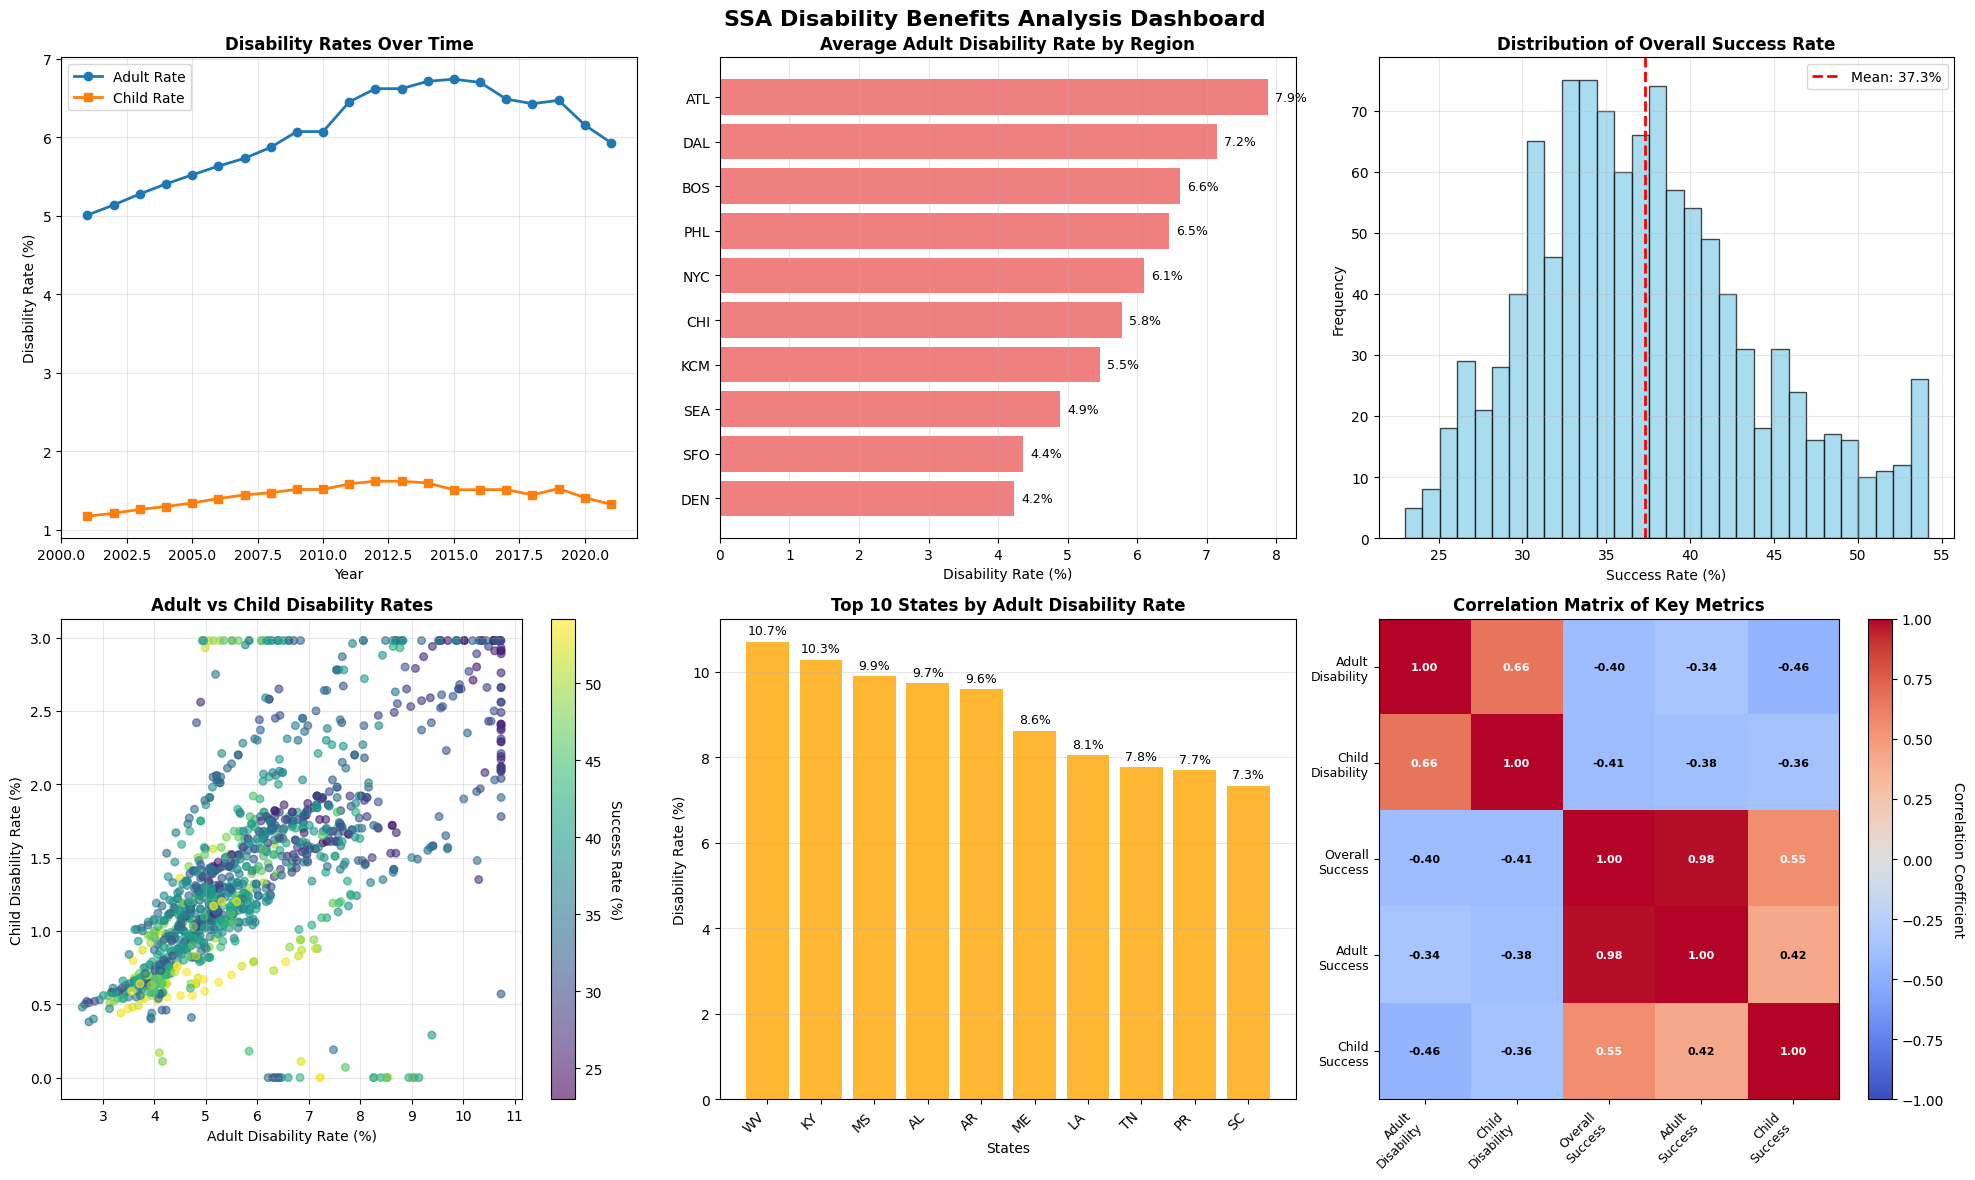

2025-07-26 11:19:27,802 - INFO - Visualizations generated successfully
2025-07-26 11:19:27,803 - INFO - Exporting results...
2025-07-26 11:19:27,811 - INFO - Cleaned data exported to ssa_analysis_cleaned_data.csv
2025-07-26 11:19:27,812 - INFO - Data quality report exported to ssa_analysis_quality_report.json
2025-07-26 11:19:27,814 - INFO - Analysis results exported to ssa_analysis_analysis_results.json
2025-07-26 11:19:27,814 - INFO - Summary report created at ssa_analysis_summary_report.txt
2025-07-26 11:19:27,814 - INFO - Pipeline execution completed successfully!



PIPELINE EXECUTION SUMMARY
Status: success
Records Processed: 1,092
Data Quality Score: 99.98%
Analysis Components: 5

Files Generated:
- ssa_analysis_cleaned_data.csv
- ssa_analysis_quality_report.json
- ssa_analysis_analysis_results.json
- ssa_analysis_summary_report.txt

Pipeline execution complete!


In [16]:
# Let's test it!🔥
if __name__ == "__main__":
    # Initialize and run the pipeline
    pipeline = SSADataPipeline("SSA-SA-FYWL.csv")
    
    # Execute the complete pipeline
    result = pipeline.run_pipeline()
    
    print("\n" + "="*50)
    print("PIPELINE EXECUTION SUMMARY")
    print("="*50)
    print(f"Status: {result['status']}")
    
    if result['status'] == 'success':
        print(f"Records Processed: {result['records_processed']:,}")
        print(f"Data Quality Score: {result['data_quality_score']:.2f}%")
        print(f"Analysis Components: {result['analysis_components_completed']}")
        print("\nFiles Generated:")
        print("- ssa_analysis_cleaned_data.csv")
        print("- ssa_analysis_quality_report.json")
        print("- ssa_analysis_analysis_results.json")
        print("- ssa_analysis_summary_report.txt")
    else:
        print(f"Error: {result.get('error', 'Unknown error')}")
    
    print("\nPipeline execution complete!")